# Willard-Chandler Instantaneous Interface Calculator
Python-based tool to calculate instantaneous interfaces and concentration/orientation profiles from molecular simulation trajectories in slab geometry.

The method is described by A.P. Willard and D. Chandler in [_Instantaneous Liquid Interfaces_](https://pubs.acs.org/doi/10.1021/jp909219k) [1]. The tool uses the Lewiner marching cubes algorithm [2] and is partly an adaptation of the willard-chandler module of the [`pytim` code](https://github.com/Marcello-Sega/pytim) by M. Sega with the addition of a routine to calculate the orientational distribution of free O-H groups at the interface [3].



In [1]:
from WCIS_functions import *
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import nglview as nv
import time

In [2]:
top = md.load('data/waterNaSCN.pdb')

In [3]:
params = initialize(filename='data/waterNaSCN.xtc',top=top,mesh=0.2,alpha=0.24,
            molecules=['O','NA','S1 C2 N3'],nskip=0,layers=[-0.1,0.1,0.3,0.5])

In [4]:
upperS = []; lowerS = []
cnt = 0
for i in range(0,params['n_frames']):
    frame = md.load_frame('data/waterNaSCN.xtc', index=i, top=top)
    upper, lower = find_isosurfaces(frame,params)
    upperS.append(upper[0])
    lowerS.append(lower[0])
    calc_profiles(frame,upper,params,label='upper',sign=1,layers=params['layers'])
    calc_profiles(frame,lower,params,label='lower',sign=-1,layers=params['layers'])
    cnt += 1

In [5]:
for atomdata in params['data'].values():
    if type(atomdata['upper']) == dict:
        atomdata['upper']['conc'] /= cnt 
        atomdata['lower']['conc'] /= cnt
        atomdata['upper']['cosine'] /= cnt 
        atomdata['lower']['cosine'] /= cnt
    else:
        atomdata['upper'] /= cnt 
        atomdata['lower'] /= cnt

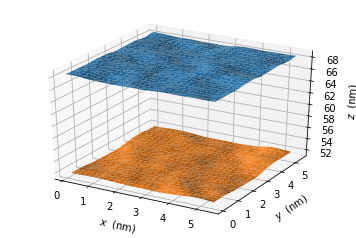

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(upperS[0][:,0],upperS[0][:,1],upperS[0][:,2])
ax.plot_trisurf(lowerS[0][:,0],lowerS[0][:,1],lowerS[0][:,2])
#plt.axis('off')
ax.set_xlabel('$x$  (nm)') 
ax.set_ylabel('$y$  (nm)')
ax.set_zlabel('$z$  (nm)')
for tick in ax.get_xaxis().get_major_ticks():
    tick.set_pad(.5)
for tick in ax.get_yaxis().get_major_ticks():
    tick.set_pad(.3)
plt.show()

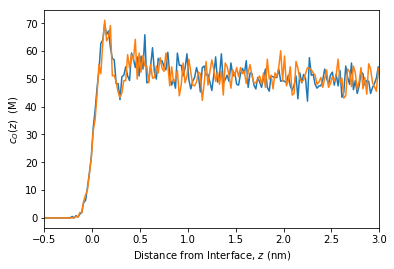

In [7]:
plt.plot(params['z'],params['data']['O']['upper'])
plt.plot(params['z'],params['data']['O']['lower'])
plt.xlim(-.5,3)
plt.xlabel(r'Distance from Interface, $z$ (nm)') 
plt.ylabel('$c_{O}(z)$  (M)') 
plt.show()

In [3]:
traj = md.load_xtc('data/waterNaSCN.xtc','data/waterNaSCN.pdb')

In [9]:
lengths = traj.unitcell_lengths.mean(axis=0)

In [10]:
def surface2pdb(surface,lengths):
    top = md.Topology()       
    chain = top.add_chain()
    xyz = []
    for pos in surface: # add CG residues and atoms
        res = top.add_residue('H', chain)
        atom = top.add_atom('H', element=md.element.argon, residue=res)
        #print(pos)
        xyz.append(pos)
    return md.Trajectory(xyz, topology=top, unitcell_lengths=lengths, unitcell_angles=[90,90,90])

In [11]:
for i,u in enumerate(upperS):
    utraj = surface2pdb(u,lengths)
    utraj.save_pdb('data/upperconf'+str(i)+'.pdb')

In [12]:
for i,l in enumerate(lowerS):
    ltraj = surface2pdb(l,lengths)
    ltraj.save_pdb('data/lowerconf'+str(i)+'.pdb')

In [8]:
v = nv.show_mdtraj(traj)
v.add_spacefill(component=0,selection='.O',radius=3.166/2,color='red',opacity=0.3)
v.add_spacefill(component=0,selection='.Na',radius=2.55/2,color='green',opacity=0.4)
v.add_spacefill(component=0,selection='.S1',radius=3.83/2,color='yellow',opacity=0.4)
v.add_spacefill(component=0,selection='.C2',radius=3.35/2,color='gray',opacity=0.4)
v.add_spacefill(component=0,selection='.N3',radius=3.7/2,color='blue',opacity=0.4)
for i in range(traj.n_frames):
    v.add_component('data/lowerconf'+str(i)+'.pdb')
    v.clear_representations(component=i+1)
for i in range(traj.n_frames):
    v.add_component('data/upperconf'+str(i)+'.pdb')
    v.clear_representations(component=i+v.n_components+traj.n_frames+1)
v.add_unitcell()
v.camera = 'perspective'
v.control.rotate([-0.5,-0.5,-0.5,-0.5])
v.center()
v.control.translate([0,0,-115])
v.control.zoom(0.8)
v

NGLWidget(max_frame=9)

In [9]:
for i in range(4):
    for i in range(traj.n_frames+1):
        if i>0:
            v.add_representation(component=i,repr_type='line',color='orange')
            v.add_representation(component=i+traj.n_frames,repr_type='line',color='orange')
            time.sleep(1)
            v.frame = i
            #if i<traj.n_frames:
            v.clear_representations(component=i)
            v.clear_representations(component=i+traj.n_frames)